In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised import SupervisedDataLoader
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
np.set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()
import logging
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.DEBUG)

28-Mar-20 11:45:39 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [47]:
from sklearn.metrics import f1_score
def calc_f1_score(predictions, y_test):
    labels = y_test.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in predictions]
    return 'f1',f1_score(labels,y_bin)

In [2]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [3]:
load_app_config()
DATA_DIRECTORY='HRAnalytics'
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "is_promoted"
input_path = get_datafolder_path()

28-Mar-20 11:45:52 - INFO - Adding D:\DataSource to system path
28-Mar-20 11:45:52 - INFO - Adding D:\MachineLearning to system path


In [4]:
filepath  = pathlib.Path(input_path).joinpath(DATA_DIRECTORY)
train_filepath = filepath.joinpath(TRAIN_FILE)
test_filepath = filepath.joinpath(TEST_FILE)

In [5]:
supervisedloader = SupervisedDataLoader(train_file=train_filepath,test_file=test_filepath,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
train_y = train_dataset[RESPONSE]

28-Mar-20 11:45:52 - INFO - Loading train_file :D:\DataSource\HRAnalytics\train.csv
28-Mar-20 11:45:53 - INFO - Loading test_file :D:\DataSource\HRAnalytics\test.csv


In [6]:
def get_nullcounts(dataset):
    nullcount_frame = pd.DataFrame({'Feature':dataset.columns.values,
                                    'Missing_Values': dataset.shape[0] - dataset.count().values, })
    nullcount_frame = nullcount_frame[nullcount_frame['Missing_Values']>0].reset_index(drop=True)
    nullcount_frame['Missing_Values%'] = (nullcount_frame['Missing_Values']/dataset.shape[0])*100
    return nullcount_frame

In [7]:
train_dataset.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,"54,808.0000","54,808.0000","54,808.0000","50,684.0000","54,808.0000","54,808.0000","54,808.0000","54,808.0000","54,808.0000"
mean,"39,195.8306",1.2530,34.8039,3.3293,5.8655,0.3520,0.0232,63.3868,0.0852
std,"22,586.5814",0.6093,7.6602,1.2600,4.2651,0.4776,0.1505,13.3716,0.2791
min,1.0000,1.0000,20.0000,1.0000,1.0000,0.0000,0.0000,39.0000,0.0000
25%,"19,669.7500",1.0000,29.0000,3.0000,3.0000,0.0000,0.0000,51.0000,0.0000
50%,"39,225.5000",1.0000,33.0000,3.0000,5.0000,0.0000,0.0000,60.0000,0.0000
75%,"58,730.5000",1.0000,39.0000,4.0000,7.0000,1.0000,0.0000,76.0000,0.0000
max,"78,298.0000",10.0000,60.0000,5.0000,37.0000,1.0000,1.0000,99.0000,1.0000


In [8]:
display(train_dataset.head())
display(test_dataset.head())

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,nan,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0000,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0000,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0000,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0000,7,0,0,61


### EDA 
##### Highly imbalanced dataset

In [9]:
print("% of target variable")
train_dataset['is_promoted'].value_counts()/train_dataset.shape[0]

% of target variable


0   0.9148
1   0.0852
Name: is_promoted, dtype: float64

### Imputing missing values

In [10]:
display(get_nullcounts(train_dataset))
display(get_nullcounts(test_dataset))

,Feature,Missing_Values,Missing_Values%
0,education,2409,4.3953
1,previous_year_rating,4124,7.5244


,Feature,Missing_Values,Missing_Values%
0,education,1034,4.4019
1,previous_year_rating,1812,7.7139


In [11]:
train_rating_by_region_department =train_dataset .groupby(['region','department']) ['previous_year_rating'].median()

In [12]:
train_rating_by_region_department.head()

region    department
region_1  Analytics    4.0000
          Finance      3.0000
          HR           4.5000
          Legal        3.0000
          Operations   4.0000
Name: previous_year_rating, dtype: float64

In [13]:
test_rating_by_region_department = test_dataset.groupby(['region','department'])['previous_year_rating'].median()

In [14]:
def impute_rating(row):
    return train_rating_by_region_department[row['region'],row['department']]

In [15]:
train_dataset['previous_year_rating'].fillna(train_dataset[train_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)

In [16]:
test_dataset['previous_year_rating'].fillna(test_dataset[test_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)

In [17]:
train_education_mode = train_dataset.groupby(['department']).agg({'education':lambda x: x.value_counts(dropna=False).index[0]}).reset_index()

In [18]:
train_education_mode

,department,education
0,Analytics,Bachelor's
1,Finance,Bachelor's
2,HR,Bachelor's
3,Legal,Bachelor's
4,Operations,Bachelor's
5,Procurement,Bachelor's
6,R&D,Bachelor's
7,Sales & Marketing,Bachelor's
8,Technology,Bachelor's


In [19]:
train_dataset['education'].fillna("Bachelor's",inplace=True)
test_dataset['education'].fillna("Bachelor's",inplace=True)

In [20]:
display(get_nullcounts(train_dataset))
display(get_nullcounts(test_dataset))

,Feature,Missing_Values,Missing_Values%


,Feature,Missing_Values,Missing_Values%


In [21]:
full_dataset = pd.concat(objs=[train_dataset,test_dataset],axis=0,sort =True).reset_index(drop=True) 

In [22]:
full_dataset['department'].value_counts() 
full_dataset['education'].value_counts() 

Bachelor's          55690
Master's & above    21429
Below Secondary      1179
Name: education, dtype: int64

In [23]:
department_encoding = {'R&D':1,'Legal':1,'HR':2,'Finance':2,
                       'Analytics':3,'Technology':4,'Procurement':4,
                       'Operations':5,'Sales & Marketing':5}

education_encoding = {"Bachelor's":3,"Master's & above":2,'Below Secondary':1}

gender_encoding = {'f':0,'m':1}
recruitment_channel_encoding = {'other':3,'sourcing':2, 'referred':1}


In [24]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78298 entries, 0 to 78297
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   KPIs_met >80%         78298 non-null  int64  
 1   age                   78298 non-null  int64  
 2   avg_training_score    78298 non-null  int64  
 3   awards_won?           78298 non-null  int64  
 4   department            78298 non-null  object 
 5   education             78298 non-null  object 
 6   employee_id           78298 non-null  int64  
 7   gender                78298 non-null  object 
 8   is_promoted           54808 non-null  float64
 9   length_of_service     78298 non-null  int64  
 10  no_of_trainings       78298 non-null  int64  
 11  previous_year_rating  78298 non-null  float64
 12  recruitment_channel   78298 non-null  object 
 13  region                78298 non-null  object 
dtypes: float64(2), int64(7), object(5)
memory usage: 8.4+ MB


In [25]:
#full_dataset['department'] =full_dataset['department'].map(department_encoding)
#full_dataset['education'] =full_dataset['education'].map(education_encoding)
full_dataset['gender'] =full_dataset['gender'].map(gender_encoding)
full_dataset['recruitment_channel'] =full_dataset['recruitment_channel'].map(recruitment_channel_encoding)
full_dataset['previous_year_rating'] =full_dataset['previous_year_rating'].astype(int)

In [26]:
full_dataset = pd.get_dummies(full_dataset, columns = ["region","department","education"],prefix="d_",drop_first = True)
train_dataset['previous_year_rating'] =train_dataset['previous_year_rating'].astype(int)
full_dataset.rename(columns={'KPIs_met >80%': 'KPIs_met_GT_80', 'awards_won?': 'awards_won'}, inplace=True)

In [27]:
full_dataset.head()

,KPIs_met_GT_80,age,avg_training_score,awards_won,employee_id,gender,is_promoted,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel,d__region_10,d__region_11,d__region_12,d__region_13,d__region_14,d__region_15,d__region_16,d__region_17,d__region_18,d__region_19,d__region_2,d__region_20,d__region_21,d__region_22,d__region_23,d__region_24,d__region_25,d__region_26,d__region_27,d__region_28,d__region_29,d__region_3,d__region_30,d__region_31,d__region_32,d__region_33,d__region_34,d__region_4,d__region_5,d__region_6,d__region_7,d__region_8,d__region_9,d__Finance,d__HR,d__Legal,d__Operations,d__Procurement,d__R&D,d__Sales & Marketing,d__Technology,d__Below Secondary,d__Master's & above
0,1,35,49,0,65438,0,0.0000,8,1,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,0,30,60,0,65141,1,0.0000,4,1,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,34,50,0,7513,1,0.0000,7,1,3,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,39,50,0,2542,1,0.0000,10,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,45,73,0,48945,1,0.0000,2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
train_dataset =full_dataset[full_dataset['is_promoted'].notnull()]
test_dataset  = full_dataset[full_dataset['is_promoted'].isnull()]
test_dataset_emp =test_dataset['employee_id']
train_y=full_dataset[full_dataset['is_promoted'].notnull()]['is_promoted']

full_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)
train_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)
test_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)


In [29]:
kfold = StratifiedKFold(n_splits=10)
from sklearn.model_selection  import  train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
test_size = 0.25
seed = 2

X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_dataset, train_y, test_size=test_size,random_state=seed)

In [30]:
X_trainmodel.head()


,KPIs_met_GT_80,age,avg_training_score,awards_won,gender,length_of_service,no_of_trainings,previous_year_rating,d__region_10,d__region_11,d__region_12,d__region_13,d__region_14,d__region_15,d__region_16,d__region_17,d__region_18,d__region_19,d__region_2,d__region_20,d__region_21,d__region_22,d__region_23,d__region_24,d__region_25,d__region_26,d__region_27,d__region_28,d__region_29,d__region_3,d__region_30,d__region_31,d__region_32,d__region_33,d__region_34,d__region_4,d__region_5,d__region_6,d__region_7,d__region_8,d__region_9,d__Finance,d__HR,d__Legal,d__Operations,d__Procurement,d__R&D,d__Sales & Marketing,d__Technology,d__Below Secondary,d__Master's & above
26984,1,43,68,0,1,5,1,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
668,0,39,68,0,0,5,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
44692,1,39,85,0,1,7,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5678,1,31,62,0,1,4,1,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
43038,0,44,61,0,0,17,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [31]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction

def select_features_by_XTree(X,y):
    model = ExtraTreesClassifier()
    model.fit(X, y.values.ravel())

    selected_features =np.array(model.feature_importances_)
    selected_features_X = pd.DataFrame(X.columns.values, columns=['name'])
    selected_features =selected_features.reshape(selected_features.shape[0],1)

    selected_features_X['model_result'] =selected_features
    selected_features_X =selected_features_X.sort_values(by='model_result',ascending=False)
    return selected_features_X

In [32]:
features_XTree = select_features_by_XTree(X_trainmodel,y_trainmodel)
features = features_XTree[features_XTree['model_result'] > 0.0002]


In [33]:
selected_features = list(features['name'].values)
",".join(selected_features)

"avg_training_score,age,length_of_service,previous_year_rating,KPIs_met_GT_80,awards_won,no_of_trainings,gender,d__Sales & Marketing,d__Operations,d__Procurement,d__Master's & above,d__Technology,d__region_2,d__Finance,d__region_7,d__region_22,d__region_13,d__region_26,d__region_15,d__region_4,d__region_27,d__region_31,d__HR,d__region_23,d__region_16,d__region_28,d__R&D,d__region_17,d__region_14,d__region_11,d__region_25,d__Below Secondary,d__region_20,d__region_10,d__region_30,d__region_29,d__region_19,d__region_8,d__Legal,d__region_5,d__region_32,d__region_12,d__region_3,d__region_6,d__region_24,d__region_21,d__region_33,d__region_9,d__region_34"

In [34]:
from yellowbrick.features import Rank1D, Rank2D 
from yellowbrick.features import RadViz

In [35]:
#features =X_trainmodel.columns.values

In [36]:
#X_trainmodel = X_trainmodel[selected_features]
#X_val =X_val[selected_features]
#test_dataset = test_dataset[selected_features]


In [38]:
from sklearn.linear_model  import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel , y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))

Accuracy: 91.972


In [39]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [40]:
SEED = 222
np.random.seed(SEED)

In [41]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [56]:
def modelfit(alg,
             X_trainmodel,
             y_trainmodel,
             X_val,
             y_val,
             performCV=True,
             printFeatureImportance=True,
             cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_trainmodel,y_trainmodel)

    #Predict training set:
    dtrain_predictions = alg.predict(X_trainmodel)
    dtrain_predprob = alg.predict_proba(X_trainmodel)[:, 1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg,
                                   X_trainmodel,
                                   y_trainmodel,
                                   cv=cv_folds,
                                   scoring='roc_auc')

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" %
          metrics.accuracy_score(y_trainmodel.values, dtrain_predictions))
    print("AUC Score (Train): %f" %
          metrics.roc_auc_score(y_trainmodel, dtrain_predprob))

    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" %
              (np.mean(cv_score), np.std(cv_score), np.min(cv_score),
               np.max(cv_score)))

    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,
                             predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [57]:
from sklearn.ensemble import GradientBoostingClassifier
predictors = list(X_trainmodel.columns)


Model Report
Accuracy : 0.9396
AUC Score (Train): 0.908542
CV Score : Mean - 0.9017413 | Std - 0.003275366 | Min - 0.8975495 | Max - 0.9053872


28-Mar-20 12:06:08 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
28-Mar-

28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 10.145
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal bold normal>) = 10.335
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Microsoft Sans Serif' (micross.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal book normal>) = 10.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Rockwell Extra Bold'

28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:08 - DEBUG - findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Perpetua' (PERI____.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Gill Sans MT Ext Condensed Bold' (GLSNECB.TTF) normal normal bold condensed>) = 10.535
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal bold condensed>) = 10.535
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: sc

28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal medium normal>) = 10.145
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Constantia' (constanb.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Corbel' (corbell.ttf) normal normal light normal>) = 10.24
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 10.24
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Yandex-UI-Icons-Private' (yandex.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) i

28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 0.33499999999999996
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Chiller' (CHILLER.T

28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Candara' (Candarab.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Cooper Black' (COOPBL.TTF) normal normal black normal>) = 10.525
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Rage Italic' (RAGE.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Lucida Fax' (LFAXD.TTF) 

28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Consolas' (consolab.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Ink Free' (Inkfree.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal regular normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Calibri' (calibriz.ttf) italic norma

28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal light normal>) = 10.24
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Arial' (arial.ttf) normal normal 400 normal>) = 0.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Informal Roman' (INFROMAN.TTF) normal normal roman normal>) = 10.145
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal light normal>) = 11.24
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal light normal>) = 10.24
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:09 - DEBUG - findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 c

28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal light normal>) = 10.24
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Candara' (Candarali.ttf) italic normal light normal>) = 11.24
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 10.24
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Calisto MT' (CALISTBI.TTF) italic normal bold normal>) = 11.335
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font '

28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal roman normal>) = 10.145
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Edwardian Script ITC' (ITCEDSCR.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal bold normal>) = 11.335
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal regular normal>) = 10.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Bradley Hand ITC'

28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Arial' (arialbi.ttf) italic normal bold normal>) = 1.335
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal bold normal>) = 11.335
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Candara' (Candaraz.ttf) italic normal bold normal>) = 11.335
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:10 - DEBUG - findfont: score(<Font 'Viner Hand ITC' (VINERITC.TTF) normal normal 400 normal>)

28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 11.335
28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:11 - DEBUG - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
28-Mar-20 12:06:1

28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Vladimir Script' (VLADIMIR.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Bauhaus 93

28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal book normal>) = 11.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Gill Sans MT' (GILI____.TTF) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Cal

28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal light normal>) = 11.24
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic 

28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 10.344999999999999
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Arial' (ariblk.ttf) normal normal black normal>) = 0.525
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Arial Rounded MT Bold' (ARLRDBD.TTF) normal normal bold normal>) = 10.335
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
28-Mar-20 12:06:12 - DEBUG - findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
28-Mar-20

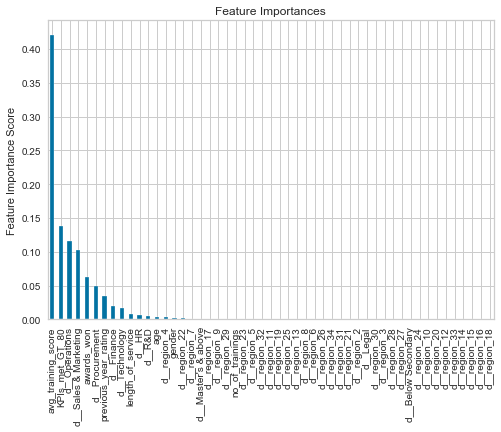

In [59]:
gbm = GradientBoostingClassifier(random_state=10)
modelfit(gbm, X_trainmodel,y_trainmodel,X_val,y_val,)

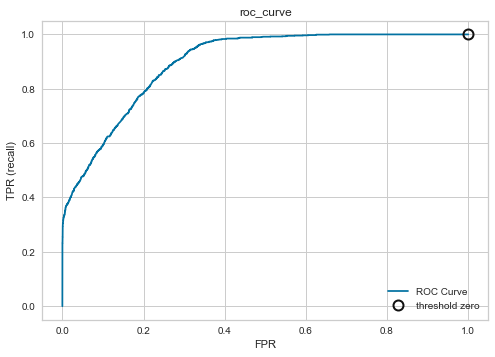

In [60]:
plot_roc(X_val,y_val,gbm)

In [61]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_trainmodel,y_trainmodel)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [73]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.9036808191553387)

In [71]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_trainmodel,y_trainmodel)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=80,
                                                  n_iter_no_change=None,
        

In [72]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 15, 'min_samples_split': 800}, 0.9092012212143757)

In [75]:
param_test3 = {'min_samples_split':range(100,800,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_trainmodel,y_trainmodel)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=15,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=80,
                                                  n_iter_no_change=None,
       

In [76]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 40, 'min_samples_split': 500}, 0.9075909641926723)

In [78]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15, 
                            min_samples_split= 500, min_samples_leaf=40 , subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_trainmodel,y_trainmodel)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=15,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=40,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=80,
                                                  n_iter_no_change=None,
      

In [80]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 13}, 0.9082529851480384)

In [83]:
best_model= gsearch4.best_estimator_


Model Report
Accuracy : 0.9445
AUC Score (Train): 0.948428
CV Score : Mean - 0.908253 | Std - 0.002852119 | Min - 0.9046188 | Max - 0.9119305


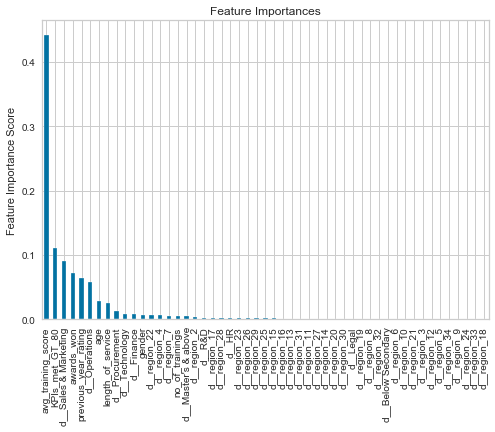

In [84]:
modelfit(best_model, X_trainmodel,y_trainmodel,X_val,y_val)

In [89]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = best_model,
                       param_grid = param_test5, scoring='f1_micro',n_jobs=4,iid=False, cv=5)

In [90]:
gsearch5.fit(X_trainmodel,y_trainmodel)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=15,
                                                  max_features=13,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=40,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=80,
                                                  n_iter_no_change=None,
        

In [95]:
gsearch5.best_params_, gsearch5.best_score_


({'subsample': 0.8}, 0.9418332816465689)

In [94]:
best_model= gsearch5.best_estimator_


Model Report
Accuracy : 0.9445
AUC Score (Train): 0.948428
CV Score : Mean - 0.908253 | Std - 0.002852119 | Min - 0.9046188 | Max - 0.9119305


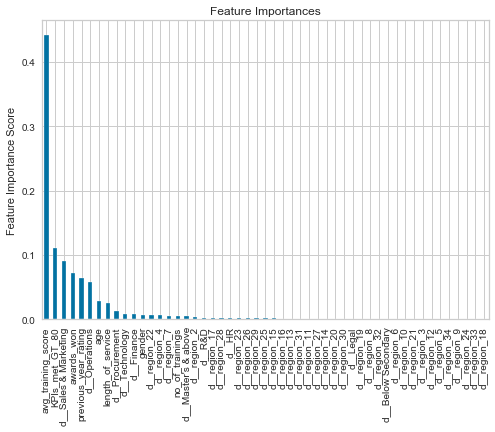

In [96]:
modelfit(best_model, X_trainmodel,y_trainmodel,X_val,y_val)

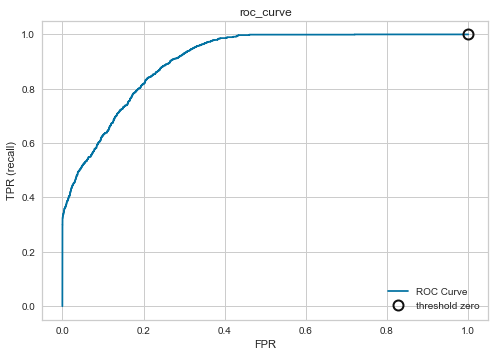

In [98]:
plot_roc(X_val,y_val,best_model)

In [99]:
test_y  =best_model.predict(test_dataset)

In [100]:
submission =pd.DataFrame({'employee_id':test_dataset_emp.values ,'is_promoted':test_y}) 
#submission['Loan_Status'].replace(0, 'N',inplace=True)
#submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="HR_Analytics_GBM"+timestamp+"_out.csv"
#submission.to_csv(filename,index=False)

In [101]:
submission.to_csv(filename,index=False)

In [53]:
# from yellowbrick.features import RFECV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(3)
# oz = RFECV(RandomForestClassifier(), cv=cv, scoring='f1_weighted')

# oz.fit(X_trainmodel, y_trainmodel)
# oz.poof()